## Day 10 : Transfer Learning

* In this section, we're going to learn how to use a pre-trained model on our use case and this is called Transfer Learning.
* We will be using VGG16 model over our Fashion MNIST dataset to predict the class labels.

#### Architecture:

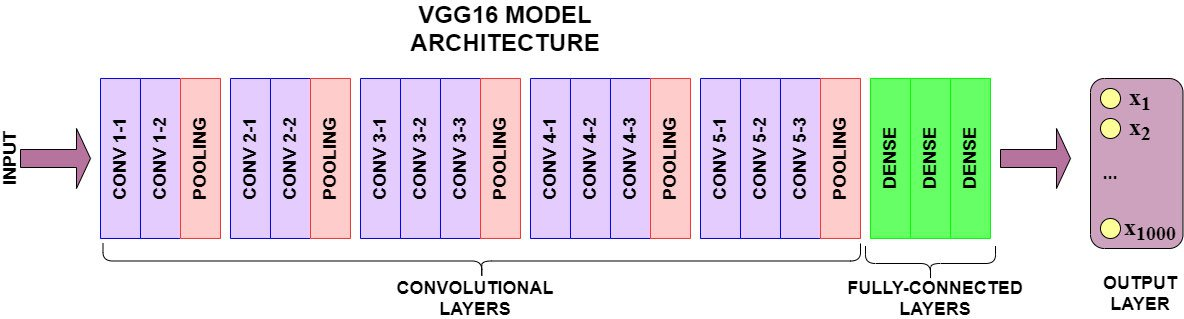

* At first we gonna build our CustomDataset Class

In [1]:
#importing standard libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
df=pd.read_csv('./data/Fashion-MNIST/fmnist_small.csv')
df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
X=df.iloc[:,1:].values
Y=df.iloc[:,:1].values
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,random_state=42,stratify=Y)

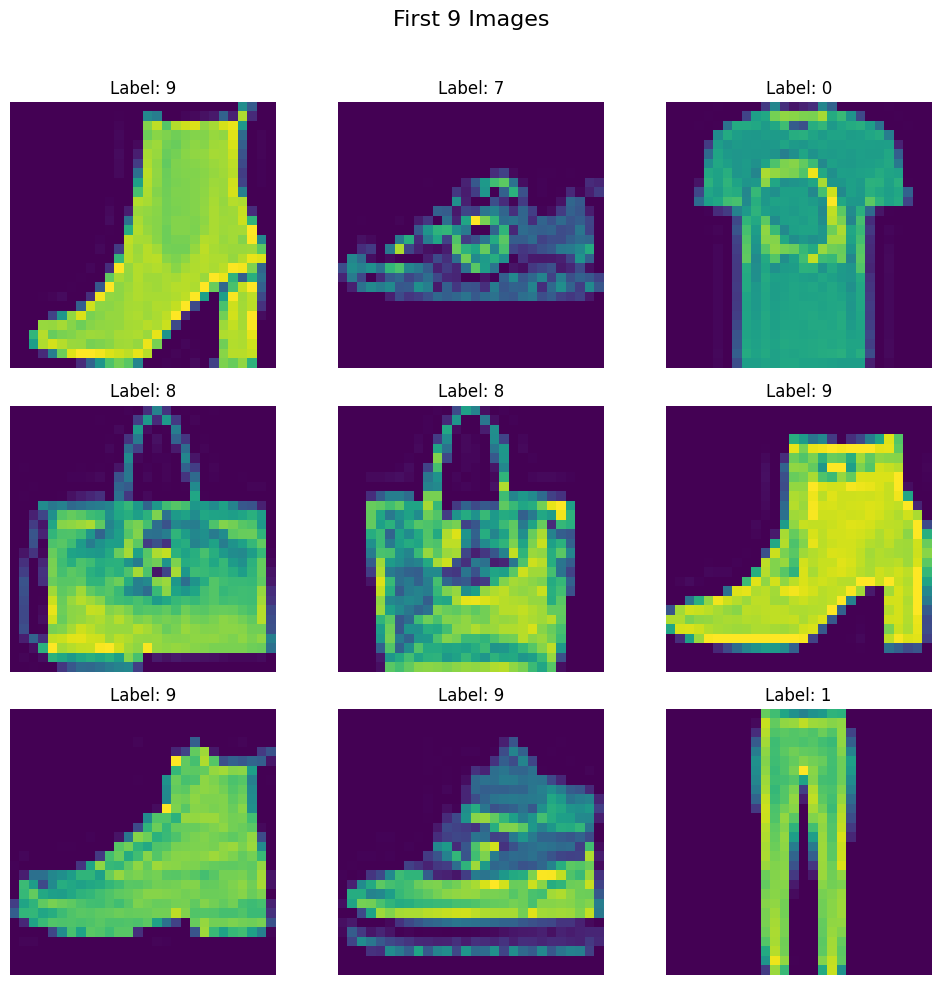

In [5]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("First 9 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [6]:
# Since VGG Net was trained on Image Net dataset, we also need to convert our images into the same format in order to use VGG Net
# The necessary transformation steps can be taken from : https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
from torchvision.transforms import transforms

custom_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
from PIL import Image
import numpy as np
class CustomDataset(Dataset):
    #constructor
    def __init__(self,features,labels,transform):
        self.features=features
        self.labels=labels
        self.transform=transform
    # Len
    def __len__(self):
        return len(self.features)
    # getitem
    def __getitem__(self, index):
        # resize image to (28,28)
        image=self.features[index].reshape(28,28)
        
        # change datatype to np.uint8 (this is because PIL images have there value in uint8 datatype format)
        image=image.astype(np.uint8)
        
        # change B&W to color -> (H,W,C) => (C,H,W)
        image=np.stack([image]*3,axis=-1)
        
        # convert array to PIL Image
        image=Image.fromarray(image)
        
        #apply transforms
        image=self.transform(image)
        
        #return
        return image,torch.tensor(np.argmax(self.labels[index]),dtype=torch.long)

In [8]:
#create train_dataset object
train_dataset=CustomDataset(X_train,Y_train,custom_transforms)

In [9]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [10]:
#Create test dataset object
test_dataset=CustomDataset(X_test,Y_test,custom_transforms)

In [11]:
#create train and test loader
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [12]:
# Fetch the pretrained model
import torchvision.models as models

vgg16=models.vgg16(pretrained=True)


c:\Users\asus\OneDrive\Documents\Projects\Pytorch 7-Days\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asus\OneDrive\Documents\Projects\Pytorch 7-Days\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
vgg16 # This is the architecture of VGG16 network that we saw above

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for params in vgg16.features.parameters(): #Freezing the convolutional layers
    params.requires_grad=False

In [15]:
vgg16.classifier=nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512,10)
)

In [16]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# Set learning rate and epochs
epochs=10
learning_rate=0.1

In [18]:


#loss function
criterion=nn.CrossEntropyLoss()

#optimizer
optimizer=optim.Adam(vgg16.classifier.parameters(),lr=learning_rate)

In [19]:
#train load dataset
len(train_loader)

169

In [ ]:
#training loop
for epoch in range(epochs):
    total_loss=0
    for batch_features,batch_labels in train_loader:
        #move data to gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
        #forward pass
        outputs=vgg16(batch_features)
        #loss calculation
        loss=criterion(outputs,batch_labels)
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        #weights update
        optimizer.step()
        
        total_loss+=loss.item()
        break
    avg_loss=total_loss/len(train_loader)
    print(f"Epoch:{epoch+1} , Loss: {avg_loss}")
        

torch.Size([32, 10])
torch.Size([32])
Epoch:1 , Loss: 0.01357707187268861
torch.Size([32, 10])
torch.Size([32])
Epoch:2 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:3 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:4 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:5 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:6 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:7 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:8 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:9 , Loss: 0.0
torch.Size([32, 10])
torch.Size([32])
Epoch:10 , Loss: 0.0


### Evaluations:

In [23]:
#set model eval mode on:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# evaluation code
total=0
correct=0
with torch.no_grad():
    for batch_features,batch_labels in test_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
        outputs=vgg16(batch_features)
        _,predictions=torch.max(outputs,1)
        total=total+batch_labels.shape[0]#len(batch_labels)
        correct=correct+(predictions==batch_labels).sum().item()
print(correct/total)

1.0
